# Pediatric Model Without Transfer

Utilizes model computed earlier on pediatric data. No finetuning is used in this notebook.

Import all needed in this notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import torch.nn.functional as F

## Model Creation

Same code for the model

In [2]:
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512) 
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

num_classes = 2
custom_model = CustomCNNModel(num_classes=num_classes)

Print the structure of the model

In [3]:
print(custom_model)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Now we load the existing weights for adult data on this model

In [4]:
custom_model.load_state_dict(torch.load("../models/modelv5.1.pth"))

C:\Users\daans\AppData\Local\Temp\ipykernel_13796\4060948717.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model.load_state_dict(torch.load("../models/modelv5.1

<All keys matched successfully>

## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [5]:
# with zipfile.ZipFile("original_data.zip", 'r') as zip_ref:
#     zip_ref.extractall("")

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="../pediatric_dataset/preprocessed_medium", transform=transform)

class_indices = {class_name: [] for class_name in dataset.classes}
for idx, (image, label) in enumerate(dataset):
    class_indices[dataset.classes[label]].append(idx)

for x in class_indices:
    print(f"{x}: {len(class_indices[x])} images")

train_indices = []
test_indices = []

for class_name in dataset.classes:
    indices = class_indices[class_name]
    train_indices.extend(indices[:int(len(indices)*.75)])
    test_indices.extend(indices[int(len(indices)*.75):len(indices)-1])

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

normal: 200 images
pneumonia: 200 images


In [7]:
print(dataset.class_to_idx)

{'normal': 0, 'pneumonia': 1}


In [8]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 300
Test dataset size: 98


In [9]:
from collections import Counter

def count_classes_in_subset(subset, original_dataset):
    subset_labels = [original_dataset.targets[idx] for idx in subset.indices]
    class_counts = Counter(subset_labels)
    class_name_counts = {original_dataset.classes[idx]: count for idx, count in class_counts.items()}
    return class_name_counts

train_class_counts = count_classes_in_subset(train_dataset, dataset)
test_class_counts = count_classes_in_subset(test_dataset, dataset)

print("Train class counts:", train_class_counts)
print("Test class counts:", test_class_counts)

Train class counts: {'normal': 150, 'pneumonia': 150}
Test class counts: {'normal': 49, 'pneumonia': 49}


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break 

Batch X shape: torch.Size([32, 3, 224, 224]), batch y shape: torch.Size([32])


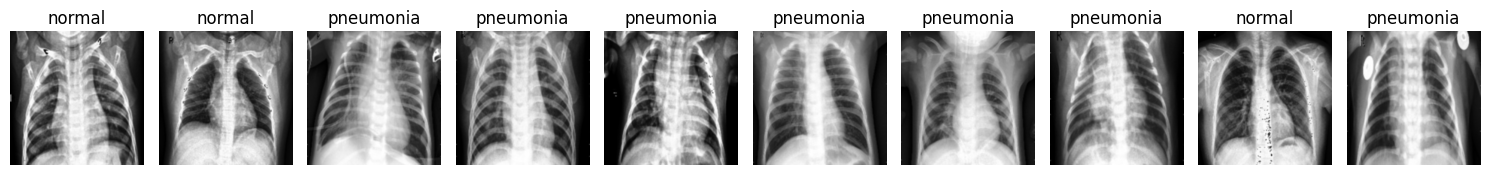

In [11]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1) 
        img = transforms.functional.to_pil_image(images[i])  
        plt.imshow(img)
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch in train_loader:
    X_batch, y_batch = batch
    class_names = dataset.classes
    display_images(X_batch[:10], y_batch[:10].tolist(), class_names)
    break

## Evaluation

In [12]:
custom_model.eval()

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model = custom_model.to(device)

In [14]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = custom_model(inputs)
        _, predicted = torch.max(outputs, 1) 
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5000
Precision: 0.5000
Recall: 0.5000
F1 Score: 0.3506
